<a href="https://colab.research.google.com/github/wsilveira-splunk/projeto_final_ciencia_dados_02_2020/blob/master/projeto_final_ciencia_dados_02_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo de Regressão Aplicado à Previsão de Preços SPOT de Energia Elétrica**


## Descrição:

  Os preços nos mercados de energia elétrica são formados utilizando-se de conceitos gerais de economia, com o equilíbrio entre a oferta e a demanda de energia. Em sistemas hidrotérmicos este equilíbrio precisa ser avaliado no longo prazo, em geral utilizando ferramentas computacionais de otimização de custos que possuem altos tempos de convergência. O objetivo deste projeto é o desenvolvimento de um modelo mais simples e rápido de definição do preço da energia, utilizando regressão, que trará vantagem competitiva para os agentes de mercado em relação à antecipação de decisões.



Clone Git Repo if it is not already cloned.

In [ ]:
%%bash

cd /content/

if [ ! -d "projeto_final_ciencia_dados_02_2020" ]; then
  git clone https://github.com/wsilveira-splunk/projeto_final_ciencia_dados_02_2020.git
fi

cd projeto_final_ciencia_dados_02_2020
git pull origin master
cd -

Already up to date.
/content


From https://github.com/wsilveira-splunk/projeto_final_ciencia_dados_02_2020
 * branch            new_data   -> FETCH_HEAD


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset_path = r'projeto_final_ciencia_dados_02_2020/dados/projecao_precos.csv'

df = pd.read_csv(dataset_path, sep=';') 

df.head

<bound method NDFrame.head of              dia         mes  ...  carga_n  pld_medio_se 
0     17/01/2013  01/01/2013  ...     3976         339.83
1     18/01/2013  01/01/2013  ...     4016         339.83
2     19/01/2013  01/01/2013  ...     3937         479.82
3     20/01/2013  01/01/2013  ...     3750         479.82
4     21/01/2013  01/01/2013  ...     4091         479.82
...          ...         ...  ...      ...            ...
1457  13/01/2017  01/01/2017  ...     5069         101.24
1458  14/01/2017  01/01/2017  ...     4831         128.50
1459  15/01/2017  01/01/2017  ...     4670         128.50
1460  16/01/2017  01/01/2017  ...     5146         128.50
1461  17/01/2017  01/01/2017  ...     5149         128.50

[1462 rows x 23 columns]>

In [ ]:
df.shape

(1462, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dia                         1462 non-null   object 
 1   mes                         1462 non-null   object 
 2   armazenamento_sin           1462 non-null   float64
 3   armazenamento_se            1462 non-null   float64
 4   armazenamento_s             1462 non-null   float64
 5   armazenamento_ne            1462 non-null   float64
 6   armazenamento_n             1462 non-null   float64
 7   ena_sin                     1462 non-null   float64
 8   ena_se                      1462 non-null   float64
 9   ena_s                       1462 non-null   float64
 10  ena_ne                      1462 non-null   float64
 11  ena_n                       1462 non-null   float64
 12  expectativa_ena_7_dias_sin  1462 non-null   float64
 13  expectativa_ena_7_dias_se   1462 

In [ ]:
df.describe()

armazenamento_sin  armazenamento_se  ...      carga_n  pld_medio_se 
count        1462.000000       1462.000000  ...  1462.000000    1462.000000
mean            0.407038          0.398303  ...  5095.934337     329.579439
std             0.113798          0.126739  ...   447.671479     246.537669
min             0.188954          0.151234  ...  3727.000000      30.250000
25%             0.320920          0.327357  ...  4920.250000     140.710000
50%             0.402954          0.370591  ...  5190.500000     270.230000
75%             0.486435          0.491432  ...  5374.750000     388.480000
max             0.633005          0.639768  ...  8231.000000     822.830000

[8 rows x 21 columns]

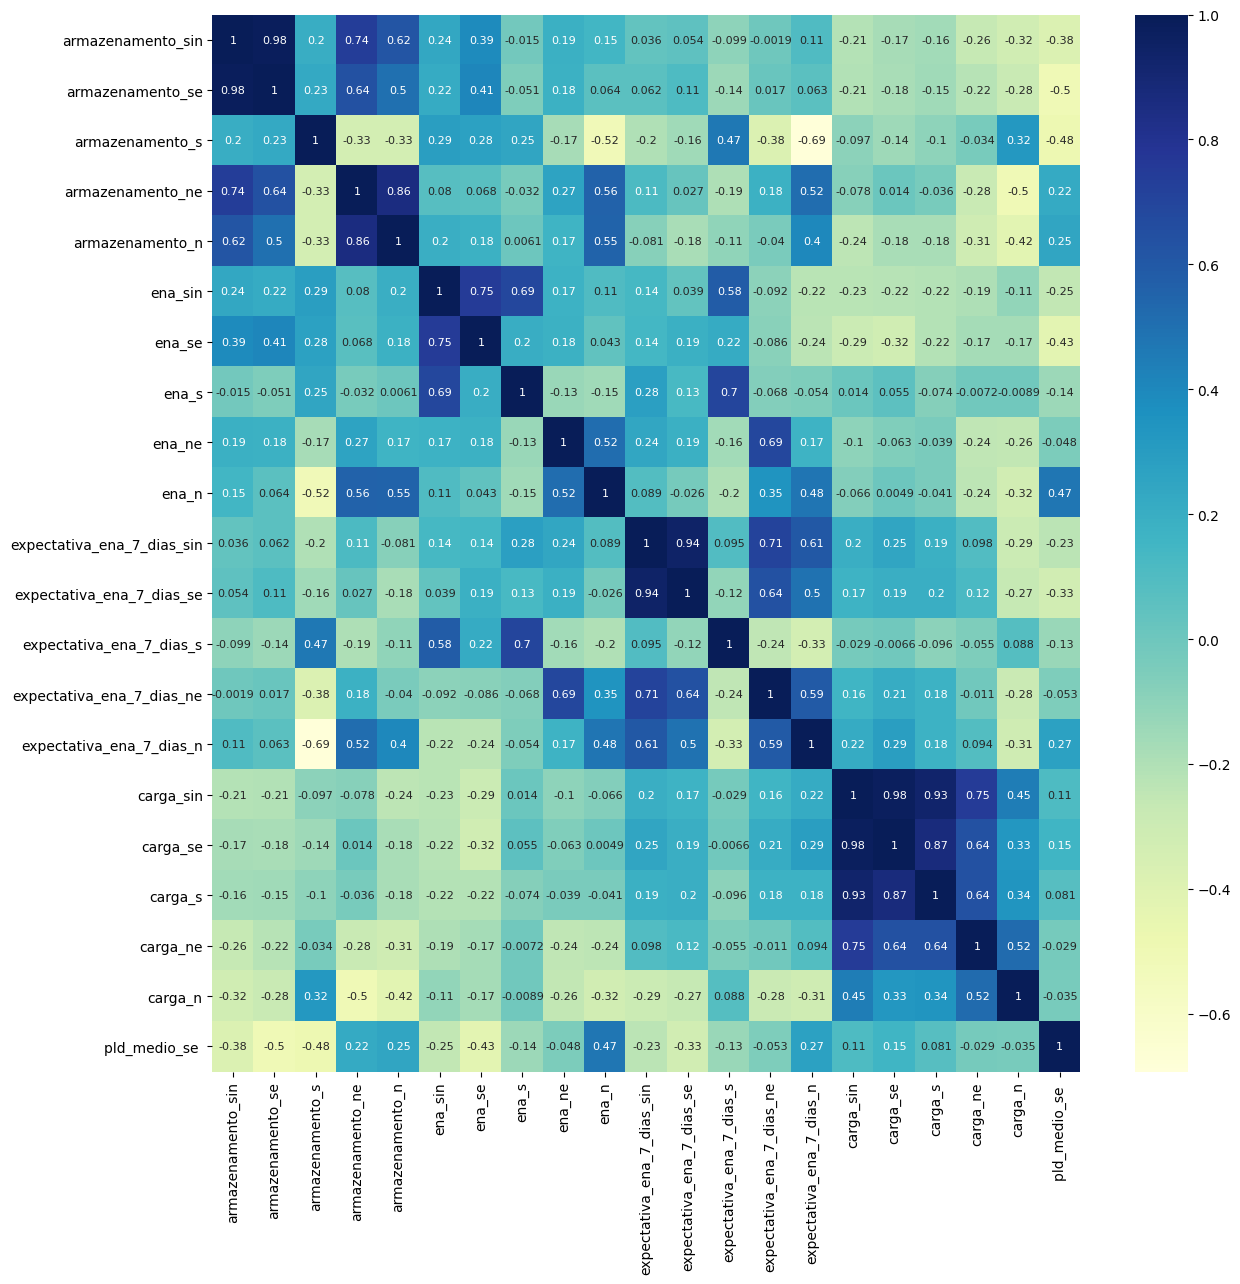

In [ ]:
fig=plt.figure(figsize=(14,14), dpi= 100, facecolor='w', edgecolor='k')

sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, annot_kws={"size":8})
plt.show()

In [ ]:
def normalize(df, columns):
    result = df.copy()
    max_value = df[columns].max()
    min_value = df[columns].min()
    result[columns] = (df[columns] - min_value) / (max_value - min_value)
    return result

df_norm = normalize(df, df.columns.values[2:])

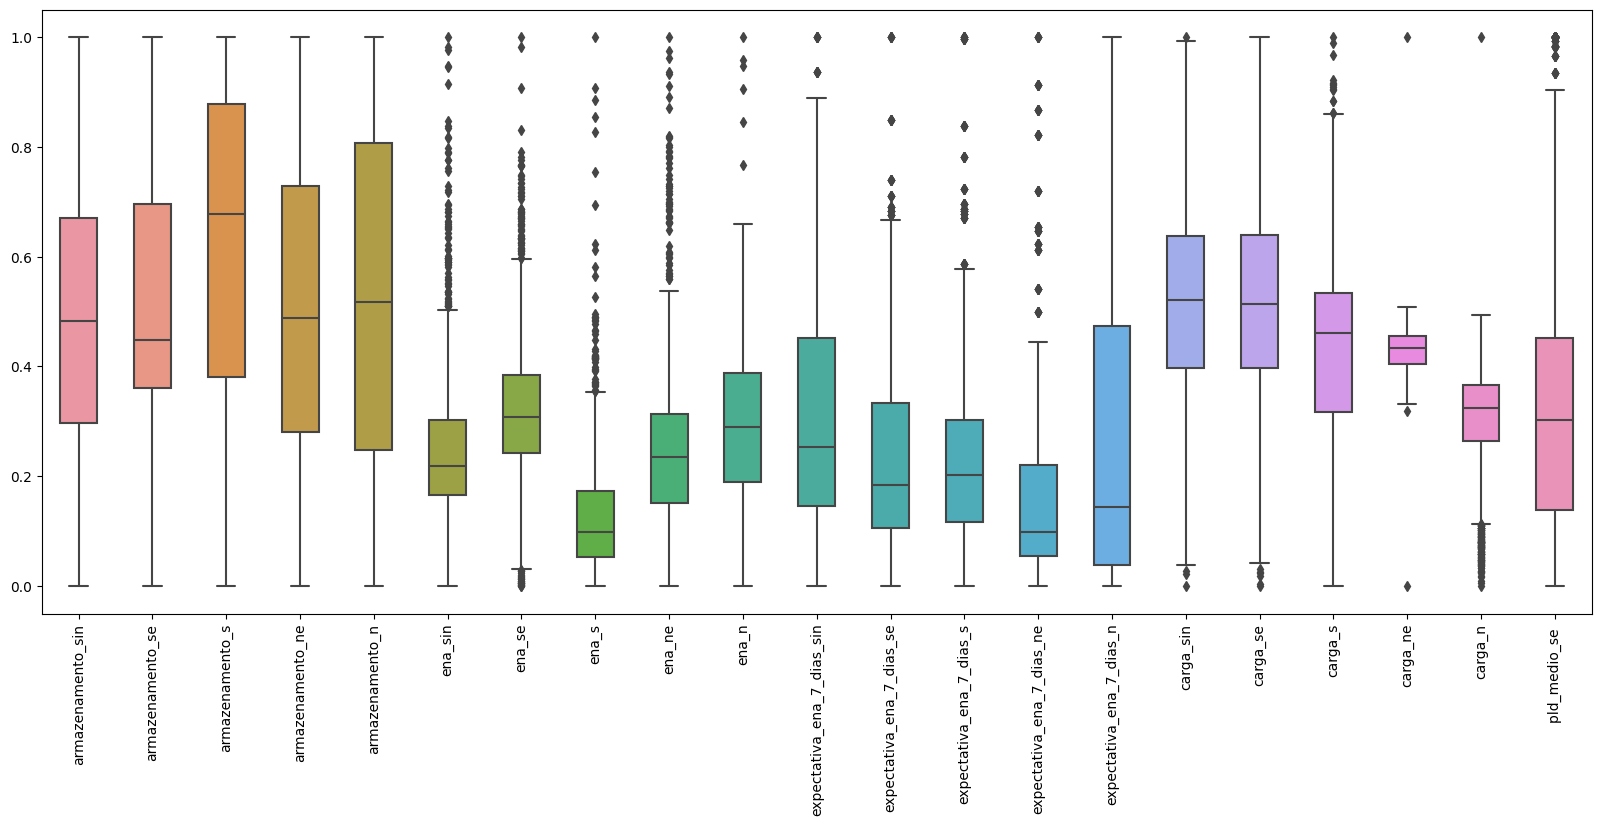

In [ ]:
fig=plt.figure(figsize=(20,8), dpi= 100)

plt.figure(1)
plt.xticks(rotation=90)

sns.set_style("whitegrid")
ax = sns.boxplot(data=df_norm, order=list(df_norm.columns.values[2:]), width=0.50)

plt.show()

In [ ]:
df_outliers = df.copy()
df_outliers.pop('mes')
df_outliers.pop('dia')

0       17/01/2013
1       18/01/2013
2       19/01/2013
3       20/01/2013
4       21/01/2013
           ...    
1457    13/01/2017
1458    14/01/2017
1459    15/01/2017
1460    16/01/2017
1461    17/01/2017
Name: dia, Length: 1462, dtype: object

In [ ]:
def remove_outlier(df, cols):
  q1 = df[cols].quantile(0.25)
  q3 = df[cols].quantile(0.75)

  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)

  for col in cols:
    df = df.loc[(df[col] > lower_bound[col]) & (df[col] < upper_bound[col])]
  return df

df_outliers = remove_outlier(df_outliers, df_outliers.columns.values)

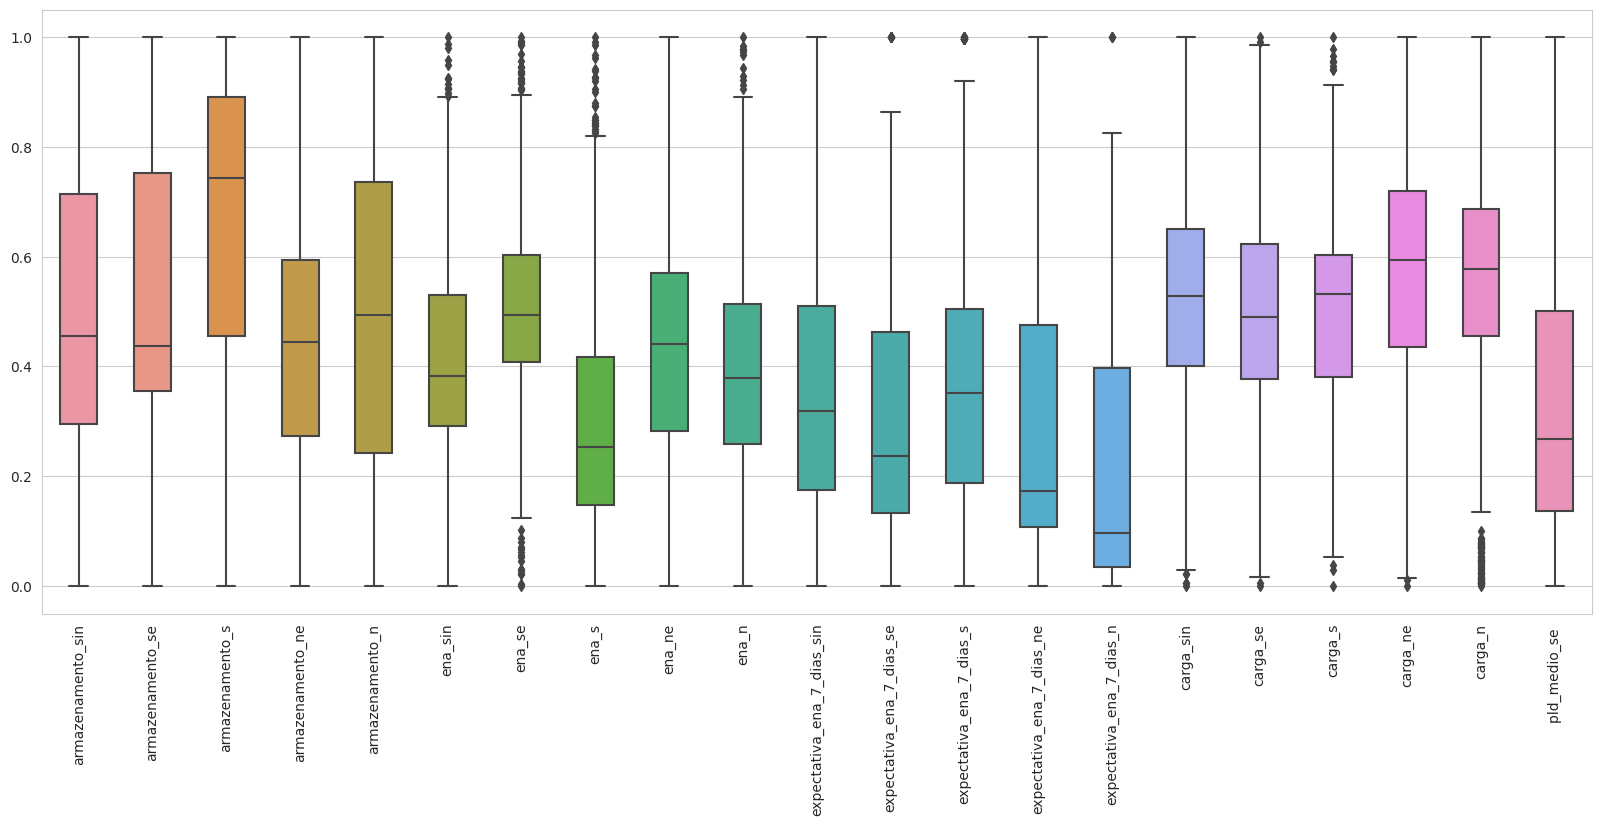

In [ ]:
def normalize(df, columns):
    result = df.copy()
    max_value = df[columns].max()
    min_value = df[columns].min()
    result[columns] = (df[columns] - min_value) / (max_value - min_value)
    return result

df_norm = normalize(df_outliers, df_outliers.columns.values)

fig=plt.figure(figsize=(20,8), dpi= 100)

plt.figure(1)
plt.xticks(rotation=90)

sns.set_style("whitegrid")
ax = sns.boxplot(data=df_norm, order=list(df_outliers.columns.values), width=0.50)

plt.show()

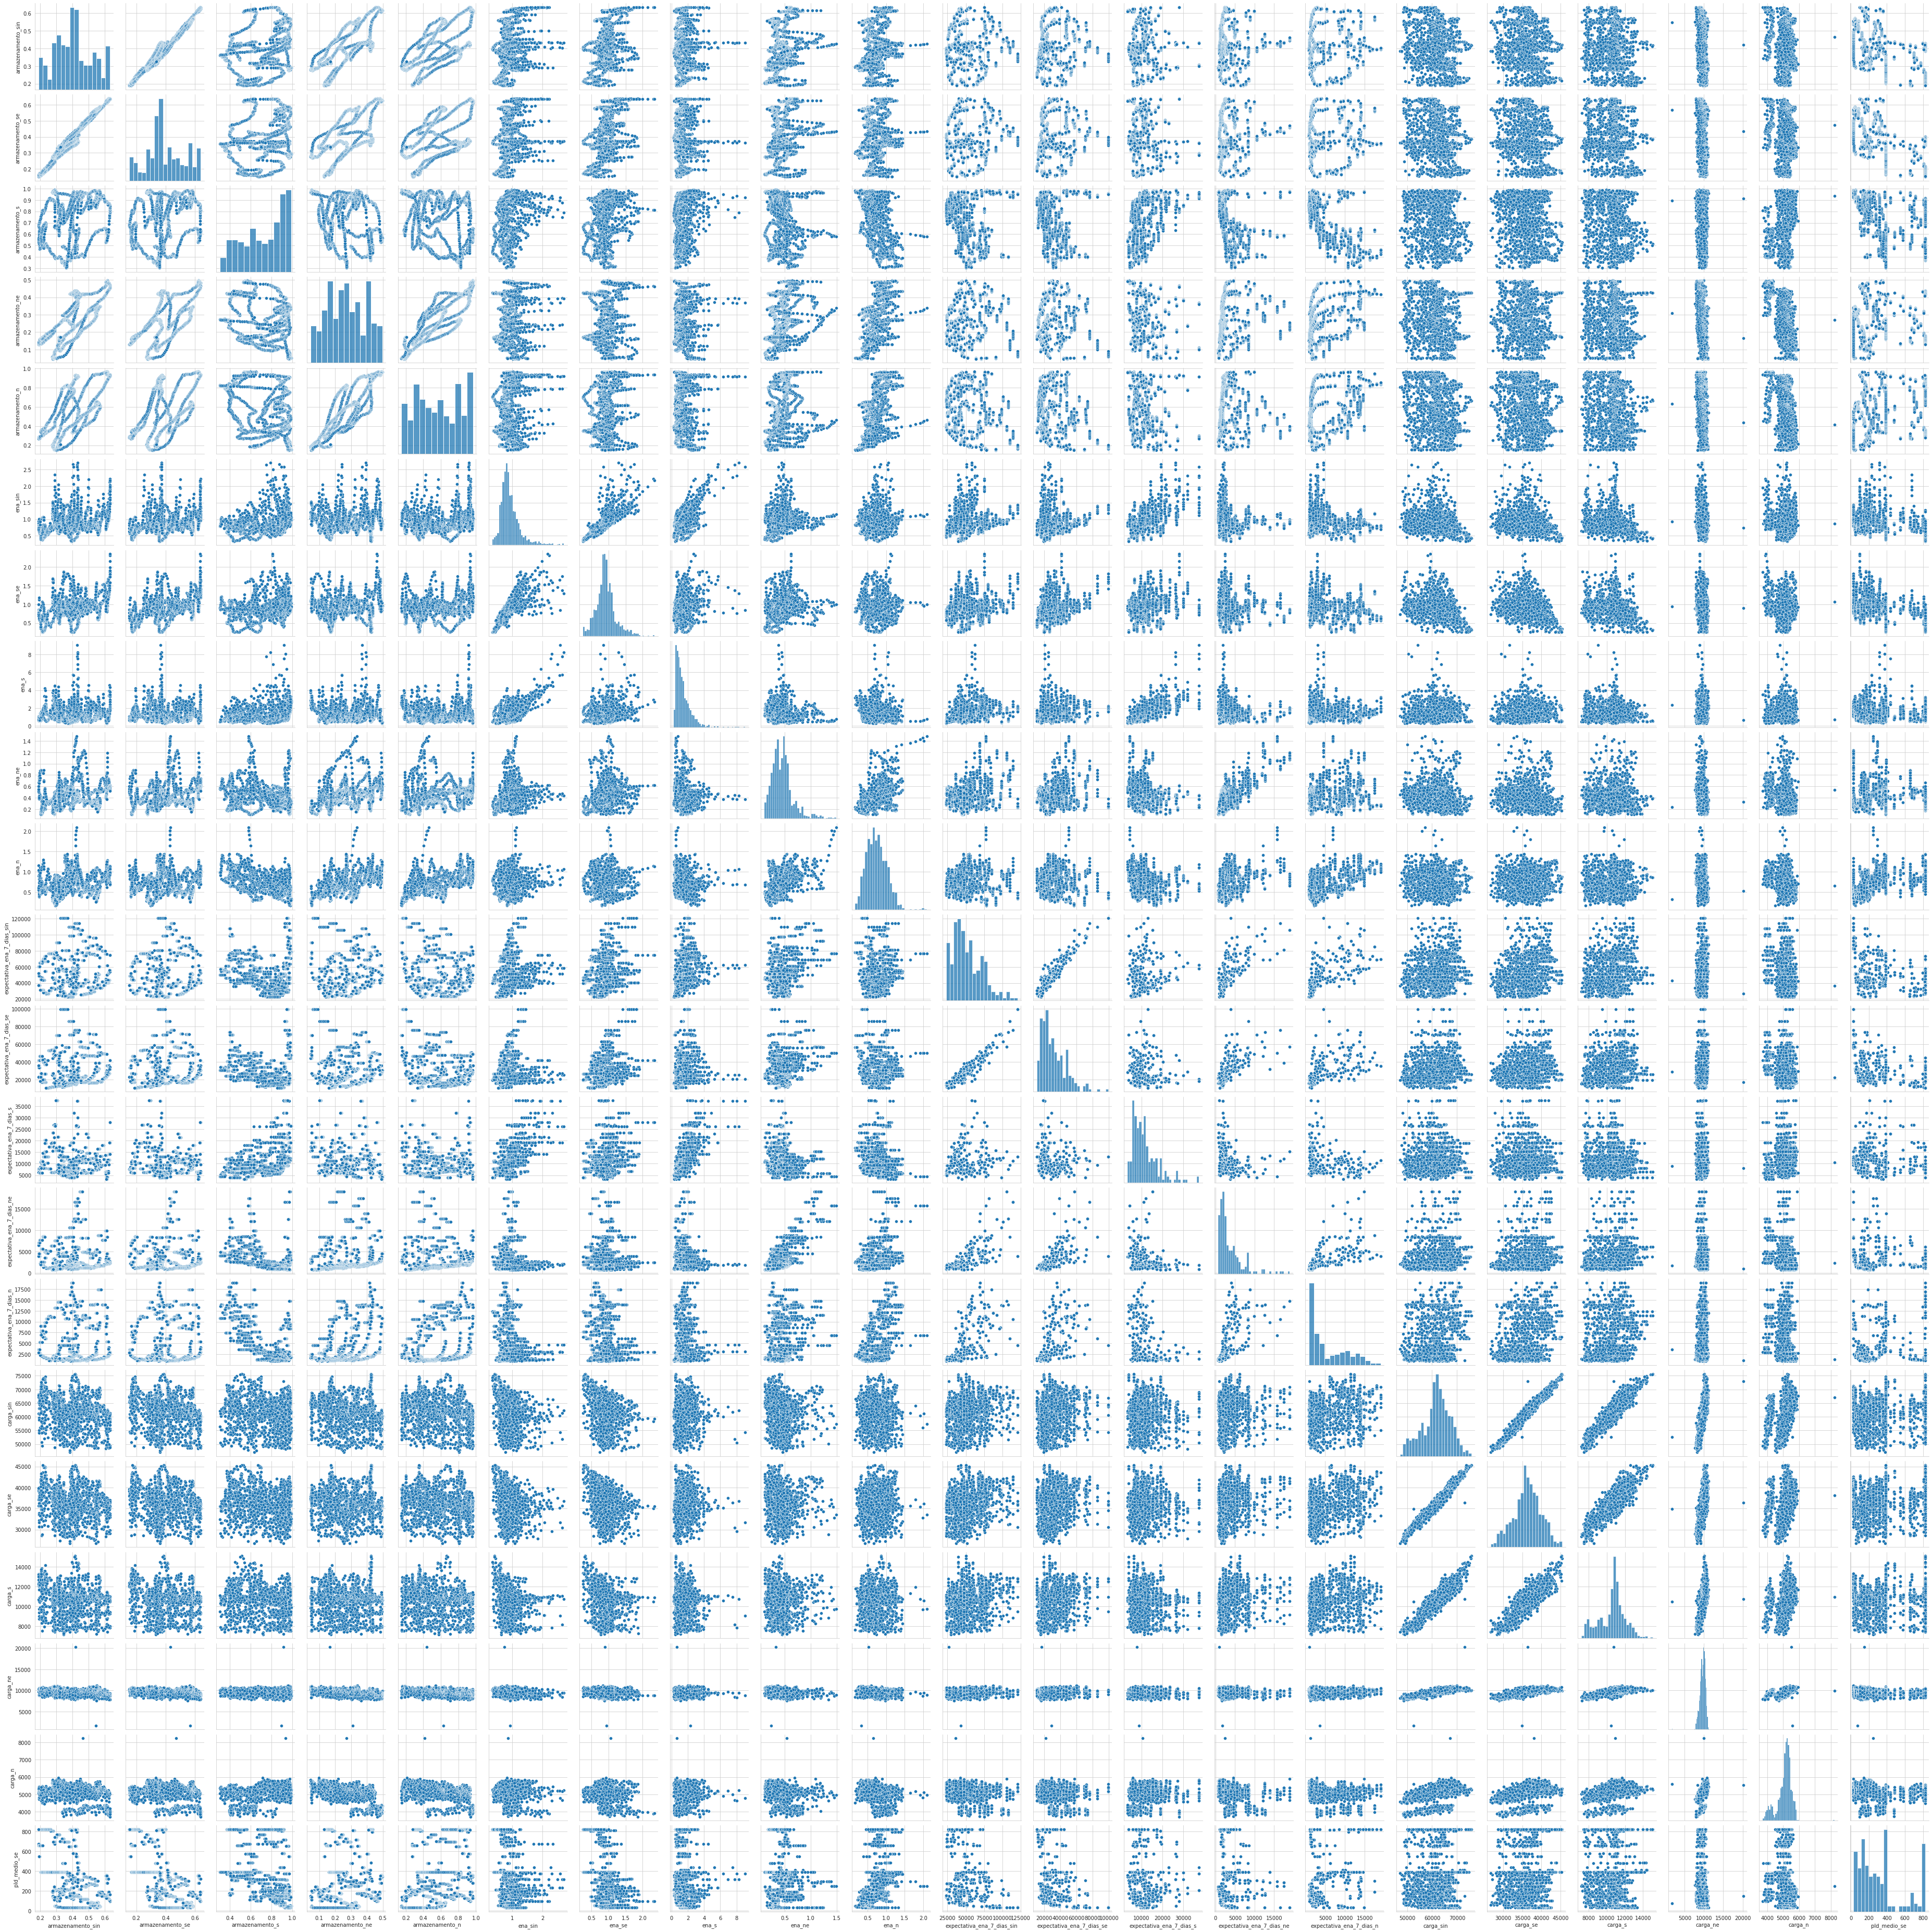

In [ ]:
sns.pairplot(df)

In [ ]:
num_vars = ['armazenamento_s', 'armazenamento_ne', 'armazenamento_n',
       'ena_sin', 'ena_se', 'ena_s', 'ena_ne', 'ena_n',
       'expectativa_ena_7_dias_sin', 'expectativa_ena_7_dias_se',
       'expectativa_ena_7_dias_s', 'expectativa_ena_7_dias_ne',
       'expectativa_ena_7_dias_n', 'carga_sin', 'carga_se', 'carga_s',
       'carga_ne', 'carga_n', 'pld_medio_se ']

df_num = df_outliers.copy()

scaler = MinMaxScaler()
df_num[num_vars] = scaler.fit_transform(df_num[num_vars])

np.random.seed(0)
df_train, df_test = train_test_split(df_num, train_size = 0.5, test_size = 0.5, random_state = 100)

In [ ]:
y_train = df_train.pop('pld_medio_se ')
X_train = df_train[df.columns[2:-1]]

In [ ]:
X_train_lr1 = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lr1).fit()

lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pld_medio_se    R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     149.5
Date:                Wed, 09 Dec 2020   Prob (F-statistic):          1.64e-174
Time:                        02:24:37   Log-Likelihood:                 444.63
No. Observations:                 459   AIC:                            -851.3
Df Residuals:                     440   BIC:                            -772.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.5446      0.692      2.233      0.026       0.185       2.904
armazenamento_sin            -12.9494     19.005     -0.681      0.496     -50.301      24.402
armazenamento_se               6.1708     13.347      0.462      0.644     -20.061      32.403
armazenamento_s                0.6156      0.889      0.692      0.489      -1.133       2.364
armazenamento_ne               2.5090      1.523      1.647      0.100      -0.485       5.503
armazenamento_n                0.3042      0.789      0.385      0.700      -1.247       1.856
ena_sin                        0.2227      0.099      2.244      0.025       0.028       0.418
ena_se                         0.0135      0.084      0.160      0.873      -0.152       0.179
ena_s                         -0.2003      0.057     -3.494      0.001      -0.313      -0.088
ena_ne                        -0.0750      0.047     -1.612      0.108      -0.166       0.016
ena_n                          0.0632      0.050      1.258      0.209      -0.036       0.162
expectativa_ena_7_dias_sin    -0.1807      0.041     -4.445      0.000      -0.261      -0.101
expectativa_ena_7_dias_se      0.0366      0.047      0.779      0.436      -0.056       0.129
expectativa_ena_7_dias_s      -0.0901      0.034     -2.644      0.008      -0.157      -0.023
expectativa_ena_7_dias_ne     -0.0345      0.054     -0.637      0.525      -0.141       0.072
expectativa_ena_7_dias_n      -0.1828      0.057     -3.188      0.002      -0.296      -0.070
carga_sin                     -0.0967      0.037     -2.601      0.010      -0.170      -0.024
carga_se                       0.0308      0.052      0.592      0.554      -0.071       0.133
carga_s                       -0.1619      0.060     -2.699      0.007      -0.280      -0.044
carga_ne                       0.2696      0.050      5.402      0.000       0.172       0.368
carga_n                       -0.0781      0.042     -1.881      0.061      -0.160       0.004
==============================================================================
Omnibus:                        2.402   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.167
Skew:                          -0.140   Prob(JB):                        0.338
Kurtosis:                       3.186   Cond. No.                     3.24e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.2e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

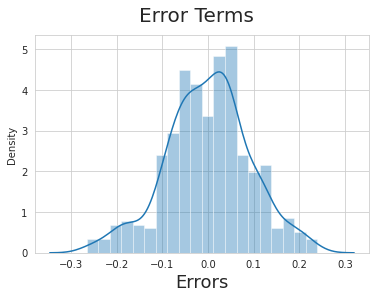

In [ ]:
y_train_price = lr_1.predict(X_train_lr1)

fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('armazenamento_sin', False, 3),
 ('armazenamento_se', False, 2),
 ('armazenamento_s', False, 5),
 ('armazenamento_ne', False, 4),
 ('armazenamento_n', False, 6),
 ('ena_sin', False, 7),
 ('ena_se', False, 11),
 ('ena_s', False, 8),
 ('ena_ne', False, 9),
 ('ena_n', False, 10),
 ('expectativa_ena_7_dias_sin', True, 1),
 ('expectativa_ena_7_dias_se', True, 1),
 ('expectativa_ena_7_dias_s', True, 1),
 ('expectativa_ena_7_dias_ne', True, 1),
 ('expectativa_ena_7_dias_n', True, 1),
 ('carga_sin', True, 1),
 ('carga_se', True, 1),
 ('carga_s', True, 1),
 ('carga_ne', True, 1),
 ('carga_n', True, 1)]

In [ ]:
multiple_linear_regression = LinearRegression()
multiple_linear_regression.fit(X_train, y_train)

y1_pred = multiple_linear_regression.predict(X_train)
r2_score(y_train, y1_pred)

0.8593448079605742

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_regression = PolynomialFeatures(degree=2)

X_train_pol = df_train[df.columns[2:-1]]

x_polynominal = polynomial_regression.fit_transform(X_train_pol)

linear_regression_poly = LinearRegression()
linear_regression_poly.fit(x_polynominal, y_train)

y_pred_pol = linear_regression_poly.predict(x_polynominal)

r2_score(y_train, y_pred_pol)

0.9914912557908776

Text(0.5, 6.79999999999999, 'Errors')

<Figure size 432x288 with 0 Axes>

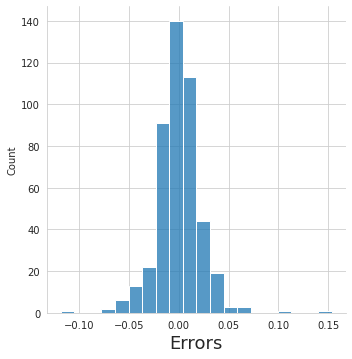

In [ ]:
fig = plt.figure()
sns.displot((y_train - y_pred_pol), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   

In [ ]:
X_test_pol = df_test[df.columns[2:-1]]
y_test_pol = df_test.pop('pld_medio_se ')

x_test_polynominal = polynomial_regression.fit_transform(X_test_pol)

y_pred_pol = linear_regression_poly.predict(x_test_polynominal)

r2_score(y_test_pol, y_pred_pol)

0.9636966989074678

Text(0.5, 6.79999999999999, 'Errors')

<Figure size 432x288 with 0 Axes>

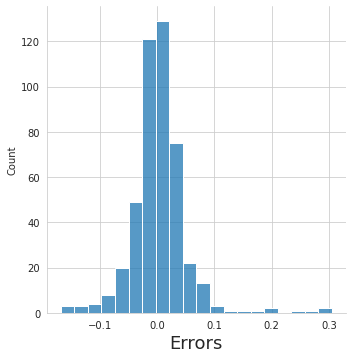

In [ ]:
fig = plt.figure()
sns.displot((y_test_pol - y_pred_pol), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   